# Usage of Computer-Aided Tagging on Commons

This dashboard displays an overview of the growth in usage of Computer-Aided Tagging on Commons. It is updated once a week, shortly after midnight UTC on Mondays.

Data prior to 2020-06-01 reflect estimates based on files available on Commons on 2020-05-29, meaning that deleted files are ignored. From 2020-06-01 onwards the data reflects the state of Commons on the given date.

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

## Table of Contents

1. [Number of Contributors](#Number-of-Contributors)
2. [Number of Files](#Number-of-Files)
3. [References](#References)

In [2]:
## Configuration variables

cat_dataset_filename = 'datasets/weekly-CAT-measurements.tsv'

In [3]:
# Packages:
library(magrittr)
library(ggplot2)
library(data.table)
import::from(dplyr, group_by, keep_where = filter, ungroup, summarize,
             mutate, rename, select, arrange, n, left_join, n_distinct, count)
import::from(tidyr, spread, gather)

In [4]:
## Helper methods, from https://github.com/bearloga/wmf-android-suggested-edits/suggested-edits-v2.ipynb
suppress_messages_warnings <- function(x) {
    suppressMessages(suppressWarnings(x))
}

In [5]:
# Read in the historic dataset
cat_dataset = fread(cat_dataset_filename) %>%
        mutate(
            snapshot_timestamp = lubridate::parse_date_time(snapshot_timestamp, c('ymd', 'ymdHMS'))
        )


In [6]:
## Query to get a dataset of all currently available CAT edits
cat_revisions_query = "
SELECT NOW() AS snapshot_timestamp, cat_edits.rev_id, actor_user, rev_page,
    IF(mobile_edits.rev_id IS NOT NULL, 1, 0) AS mobile_edit,
    IF(android_edits.rev_id IS NOT NULL, 1, 0) AS android_edit
FROM (
    SELECT rv.rev_id, coalesce(ac.actor_user, 0) AS actor_user, rev_timestamp, rev_page
    FROM revision rv
    INNER JOIN change_tag ct
    ON rev_id = ct_rev_id
    INNER JOIN change_tag_def ctd
    ON ct_tag_id = ctd_id
    INNER JOIN revision_actor_temp rat
    ON rv.rev_id = rat.revactor_rev
    INNER JOIN actor ac
    ON rat.revactor_actor = ac.actor_id
    WHERE ctd_name IN ('computer-aided-tagging', 'computer-aided-tagging-manual')
) AS cat_edits
LEFT JOIN (
    SELECT ct_rev_id AS rev_id
    FROM change_tag
    JOIN change_tag_def
    ON ct_tag_id = ctd_id
    WHERE ctd_name = 'mobile edit'
) AS mobile_edits
ON cat_edits.rev_id = mobile_edits.rev_id
LEFT JOIN  (
    SELECT ct_rev_id AS rev_id
    FROM change_tag
    JOIN change_tag_def
    ON ct_tag_id = ctd_id
    WHERE ctd_name = 'android app edit'
) AS android_edits
ON cat_edits.rev_id = android_edits.rev_id"

In [7]:
cat_revisions = suppress_messages_warnings(
    wmfdata::mysql_read(cat_revisions_query, 'commonswiki') %>%
        mutate(
            snapshot_timestamp = lubridate::ymd_hms(snapshot_timestamp)
        )
    )

In [8]:
## Generate summary statistics for the current snapshot

count_cat_contribs = function(cat_data) {
    ## From a dataset of CAT-tagged revisions, generate a data.table with summary statistics
    
    snapshot_timestamps = cat_data$snapshot_timestamp[1:4]
    snapshot_methods = rep('live', 4)
    platforms = c('all', 'desktop', 'mobile', 'android')
    
    ## Overall counts of number of contributors making CAT edits,
    ## and number of files with CAT edits:
    n_c_all = n_distinct(cat_data$actor_user)
    n_f_all = n_distinct(cat_data$rev_page)
    
    n_c_desktop = n_distinct(cat_data$actor_user[cat_data$mobile_edit == 0])
    n_f_desktop = n_distinct(cat_data$rev_page[cat_data$mobile_edit == 0])
    
    n_c_mobile = n_distinct(cat_data$actor_user[cat_data$mobile_edit == 1 & cat_data$android_edit == 0])
    n_f_mobile = n_distinct(cat_data$rev_page[cat_data$mobile_edit == 1 & cat_data$android_edit == 0])
    
    n_c_android = n_distinct(cat_data$actor_user[cat_data$android_edit == 1])
    n_f_android = n_distinct(cat_data$rev_page[cat_data$android_edit == 1])
    
    return(
        data.table(
            snapshot_timestamp = snapshot_timestamps,
            snapshot_method = snapshot_methods,
            platform = platforms,
            n_contributors = c(n_c_all, n_c_desktop, n_c_mobile, n_c_android),
            n_files = c(n_f_all, n_f_desktop, n_f_mobile, n_f_android)
        )
    )
}

In [9]:
cat_summary = count_cat_contribs(cat_revisions)

In [10]:
## Add cat_summary to the dataset

cat_dataset = rbindlist(list(cat_dataset, cat_summary))

In [11]:
# Write out the new dataset
write.table(cat_dataset, cat_dataset_filename, sep = '\t',
            row.names = FALSE, quote = FALSE)

## Number of Contributors

### Overall

In [22]:
cat(paste("Overall number of contributors making CAT edits:",
          tail(cat_dataset[platform == 'all']$n_contributors, 1)))

Overall number of contributors making CAT edits: 3672

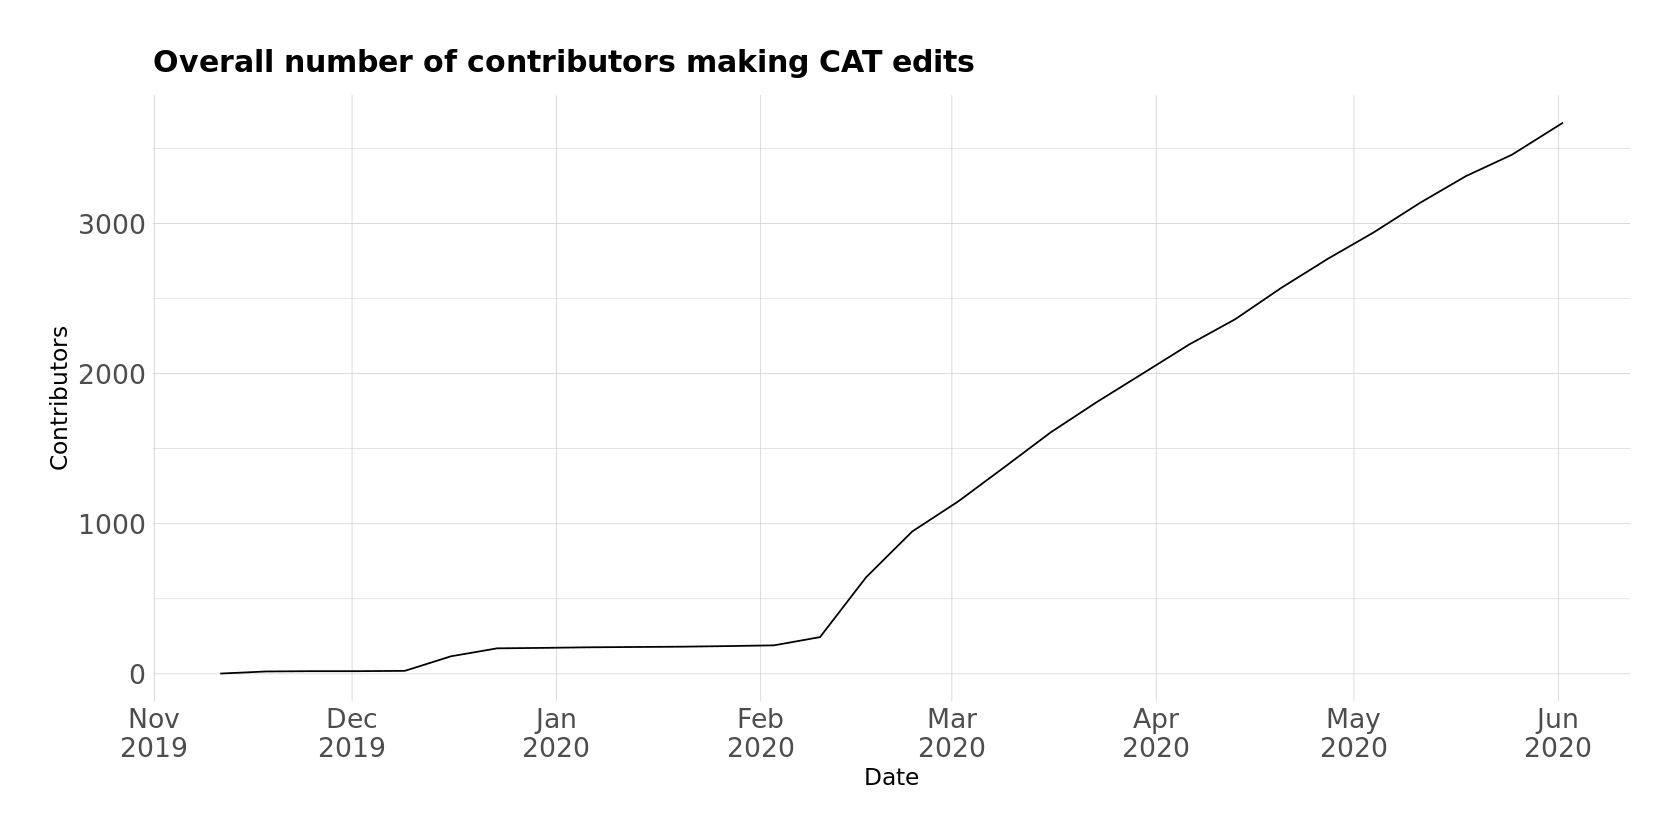

In [11]:
options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(cat_dataset[platform == 'all'],
       aes(x = snapshot_timestamp, y = n_contributors)) +
    scale_y_continuous() +
    scale_x_datetime(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    labs(x = "Date", y = "Contributors",
         title = "Overall number of contributors making CAT edits") +
    geom_line()

### Desktop

In [23]:
cat(paste("Number of contributors making CAT edits on desktop:",
          tail(cat_dataset[platform == 'desktop']$n_contributors, 1)))

Number of contributors making CAT edits on desktop: 3377

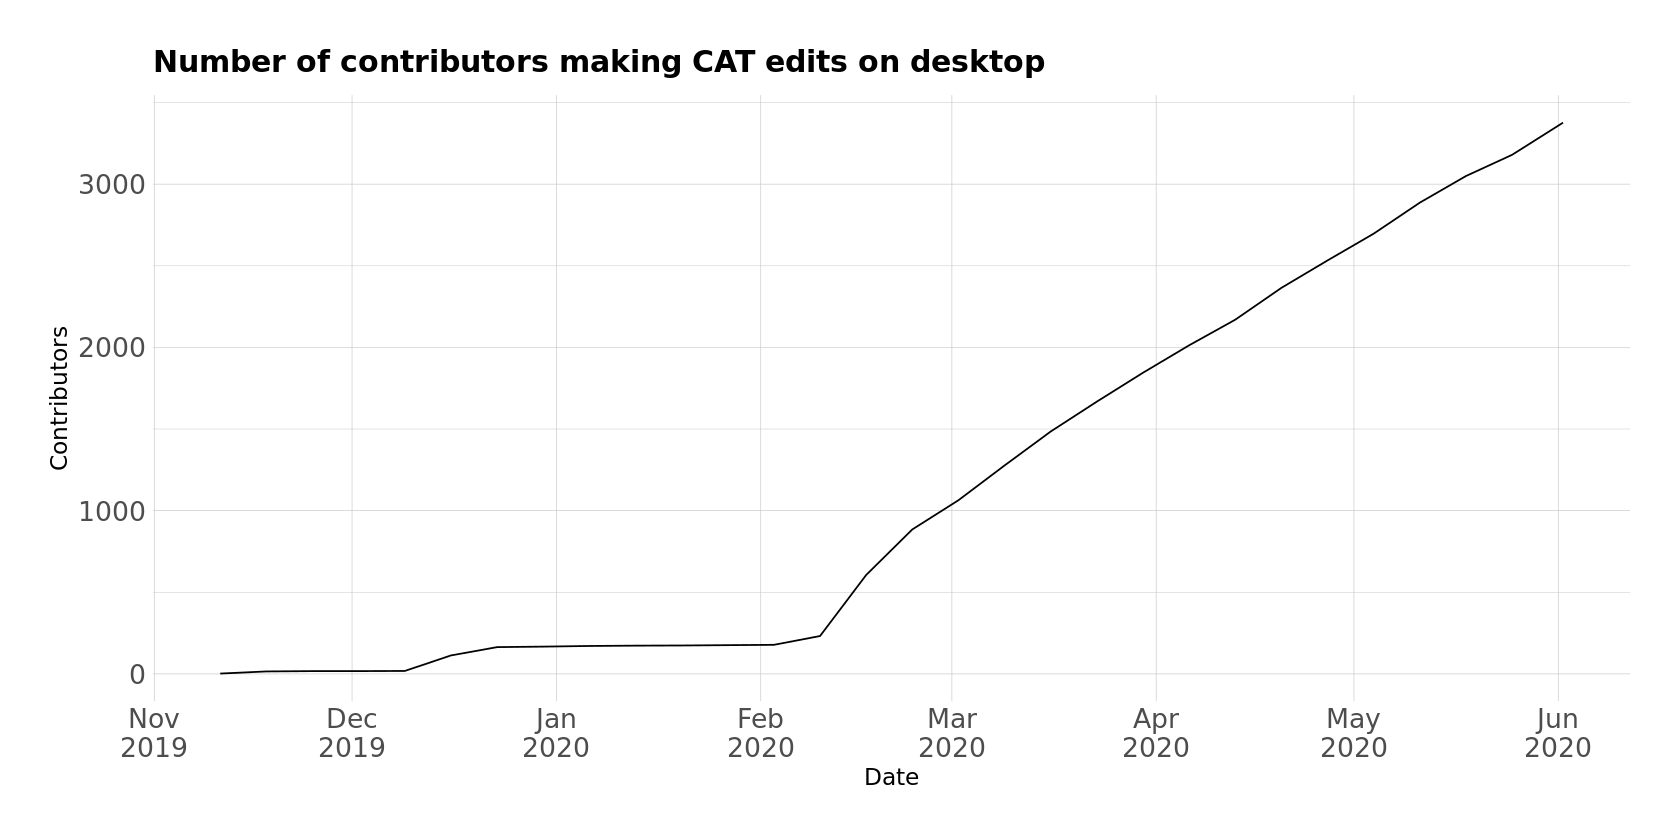

In [12]:
options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(cat_dataset[platform == 'desktop'],
       aes(x = snapshot_timestamp, y = n_contributors)) +
    scale_y_continuous() +
    scale_x_datetime(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    labs(x = "Date", y = "Contributors",
         title = "Number of contributors making CAT edits on desktop") +
    geom_line()

### Mobile

In [24]:
cat(paste("Number of contributors making CAT edits on mobile (excluding Android app edits):",
          tail(cat_dataset[platform == 'mobile']$n_contributors, 1)))

Number of contributors making CAT edits on mobile (excluding Android app edits): 507

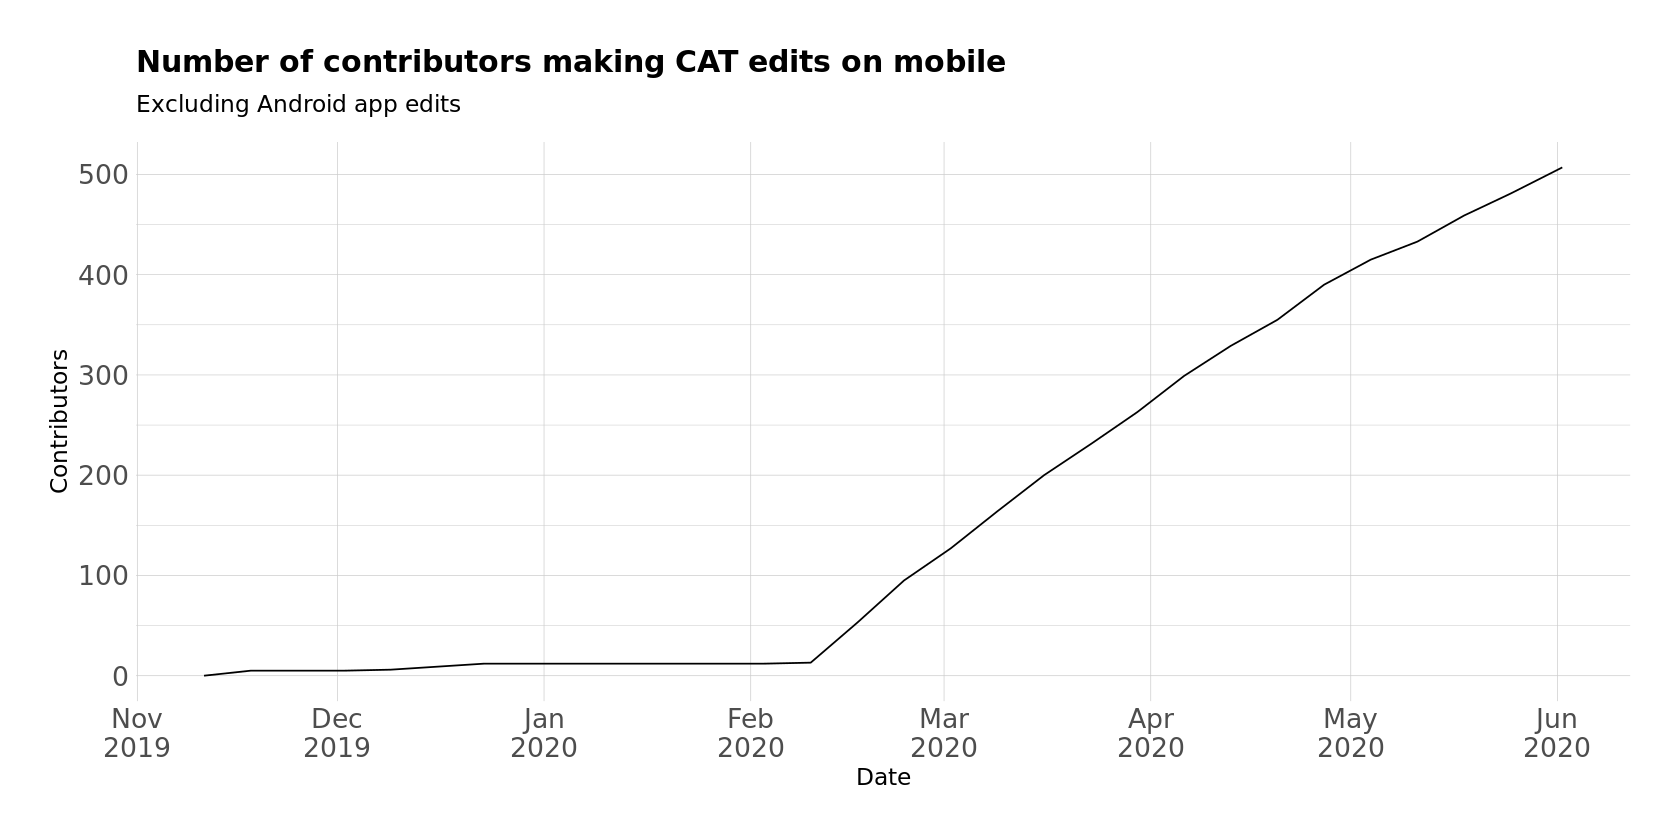

In [13]:
options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(cat_dataset[platform == 'mobile'],
       aes(x = snapshot_timestamp, y = n_contributors)) +
    scale_y_continuous() +
    scale_x_datetime(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    labs(x = "Date", y = "Contributors",
         title = "Number of contributors making CAT edits on mobile",
         subtitle = "Excluding Android app edits") +
    geom_line()

## Number of Files

### Overall

In [28]:
cat(paste("Overall number of files with CAT edits:",
          tail(cat_dataset[platform == 'all']$n_files, 1)))

Overall number of files with CAT edits: 109669

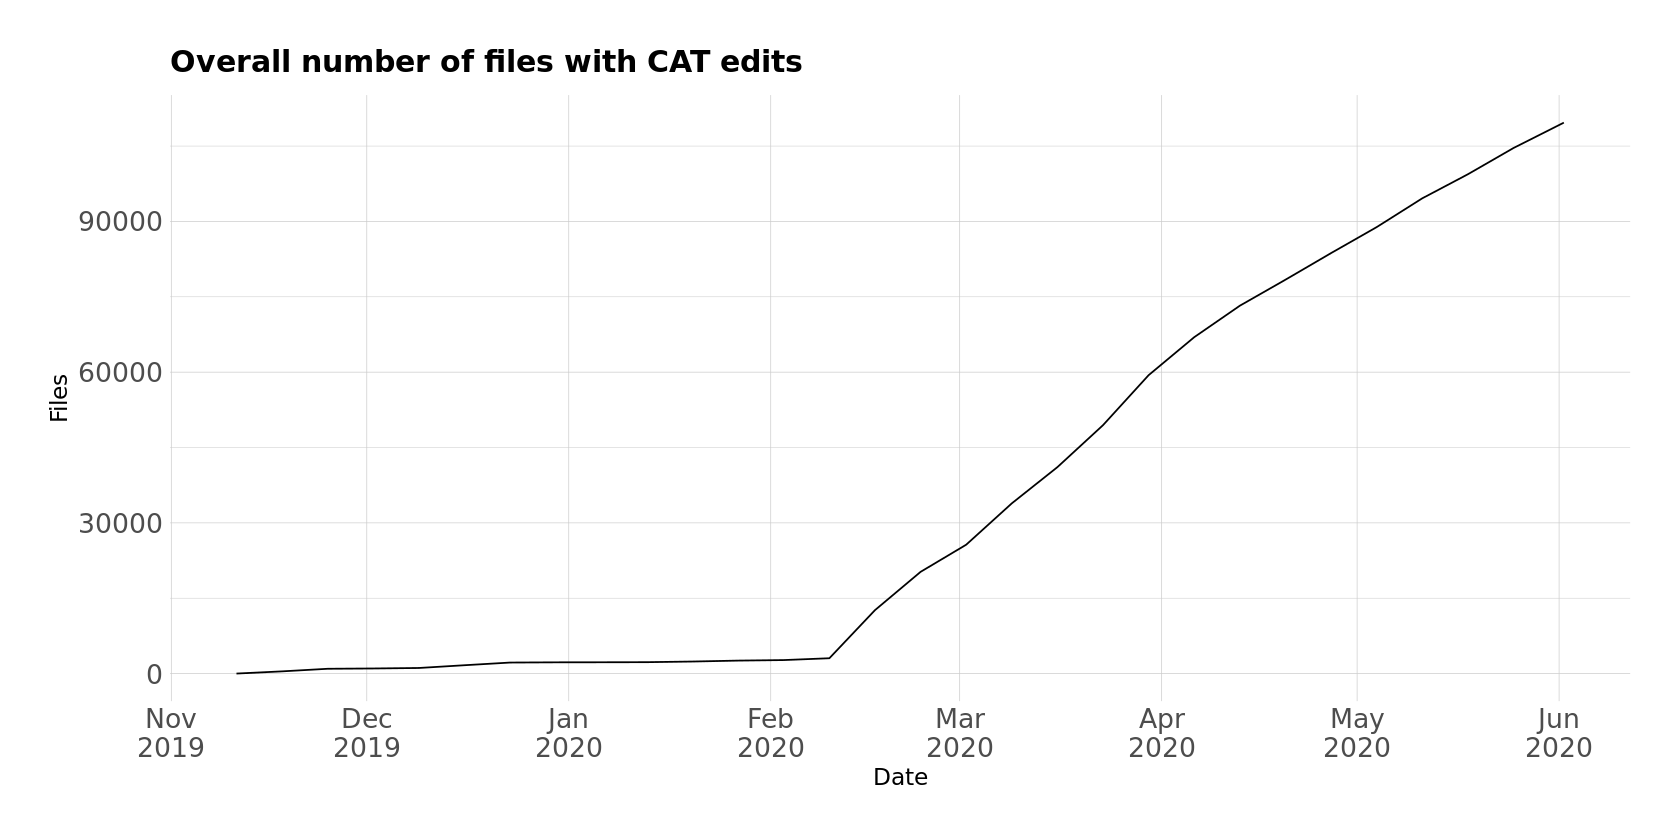

In [15]:
options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(cat_dataset[platform == 'all'],
       aes(x = snapshot_timestamp, y = n_files)) +
    scale_y_continuous() +
    scale_x_datetime(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    labs(x = "Date", y = "Files",
         title = "Overall number of files with CAT edits") +
    geom_line()

### Desktop

In [27]:
cat(paste("Number of files with CAT edits on desktop:",
          tail(cat_dataset[platform == 'desktop']$n_files, 1)))

Number of files with CAT edits on desktop: 100931

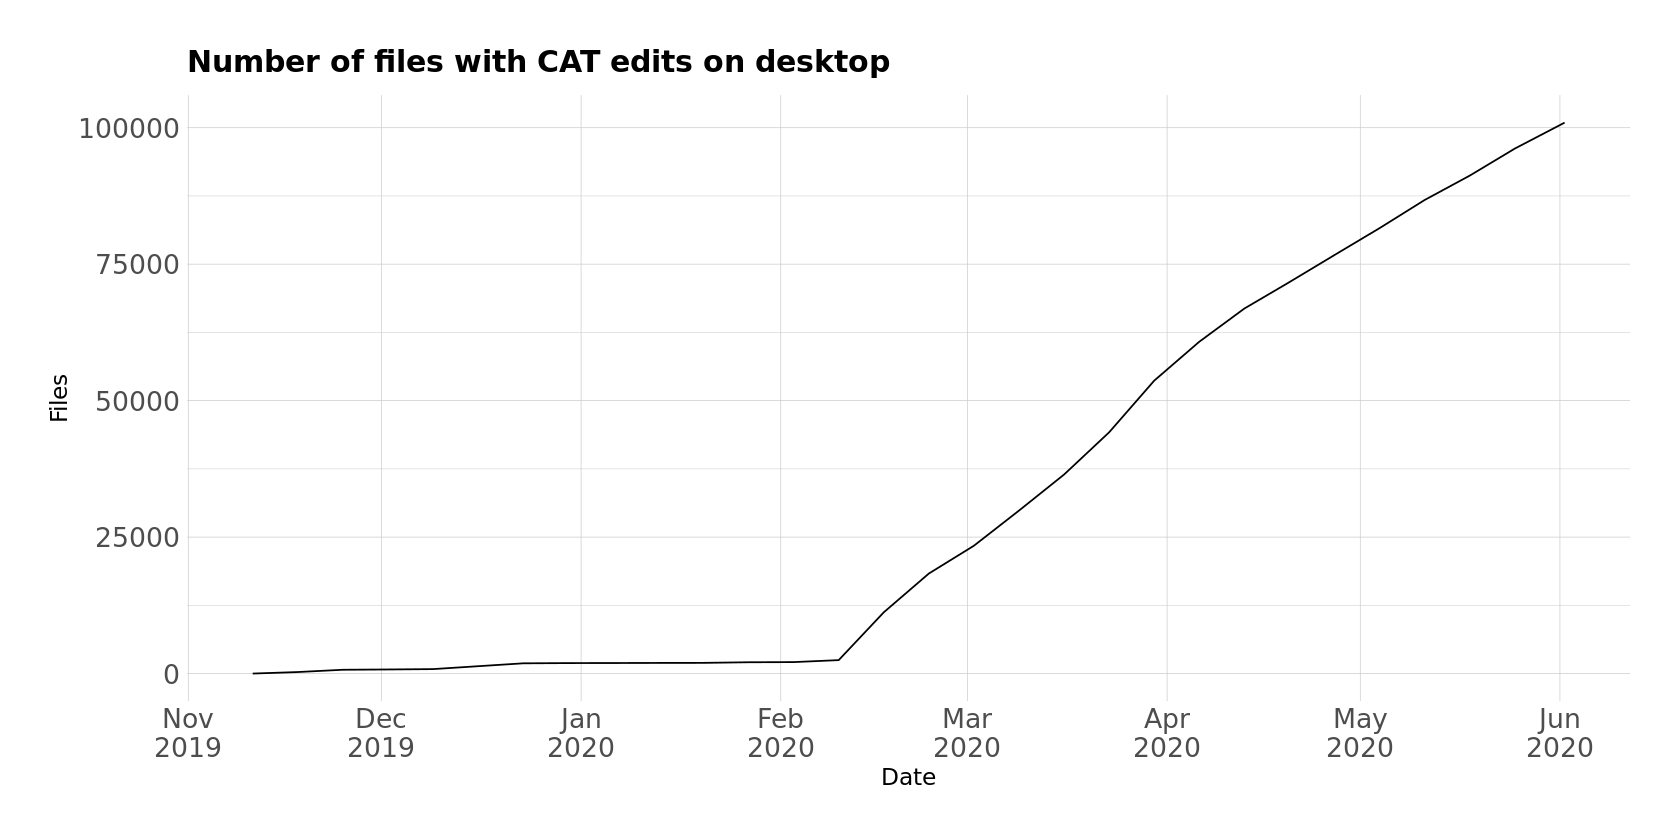

In [16]:
options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(cat_dataset[platform == 'desktop'],
       aes(x = snapshot_timestamp, y = n_files)) +
    scale_y_continuous() +
    scale_x_datetime(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    labs(x = "Date", y = "Files",
         title = "Number of files with CAT edits on desktop") +
    geom_line()

### Mobile

In [29]:
cat(paste("Number of files with CAT edits on mobile (excluding Android app edits):",
          tail(cat_dataset[platform == 'mobile']$n_files, 1)))

Number of files with CAT edits on mobile (excluding Android app edits): 8508

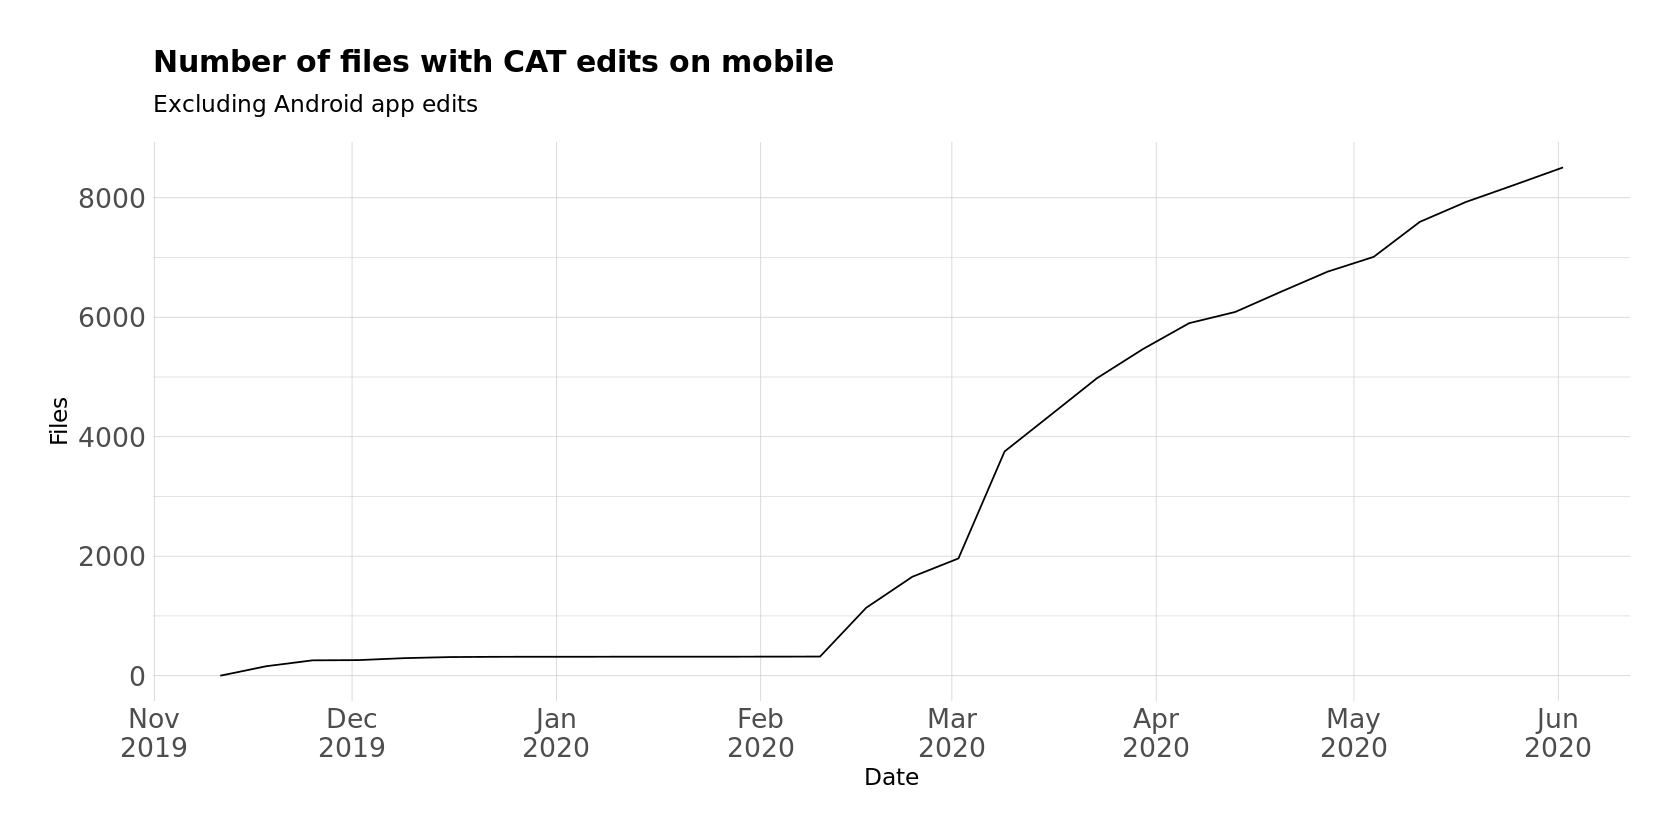

In [17]:
options(repr.plot.width = 14, repr.plot.height = 7)
ggplot(cat_dataset[platform == 'mobile'],
       aes(x = snapshot_timestamp, y = n_files)) +
    scale_y_continuous() +
    scale_x_datetime(date_breaks = "1 month", minor_breaks = NULL, date_labels = "%b\n%Y") +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
    labs(x = "Date", y = "Files",
         title = "Number of files with CAT edits on mobile",
         subtitle = "Excluding Android app edits") +
    geom_line()

## References

The Phabricator task for this work is [T251637](https://phabricator.wikimedia.org/T251637). The underlying code is stored in [this GitHub repository](https://github.com/wikimedia-research/CAT-measurements-2020). For more information about this report or to bring up issues, contact [Morten Warncke-Wang](https://meta.wikimedia.org/wiki/User:MWang_(WMF)). For more information about Computer-Aided Tagging on Commons, [see the project page on Commons](https://commons.wikimedia.org/wiki/Commons:Structured_data/Computer-aided_tagging).

In [19]:
cat("Report generated on", format(lubridate::now(), "%Y-%m-%d at %H:%M:%S UTC"))

Report generated on 2020-06-15 at 20:45:21 UTC